# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [29]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [30]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [31]:
print("Number of data points in train(resource) data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)
#project_data.head(10)


Number of data points in train(resource) data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

# 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


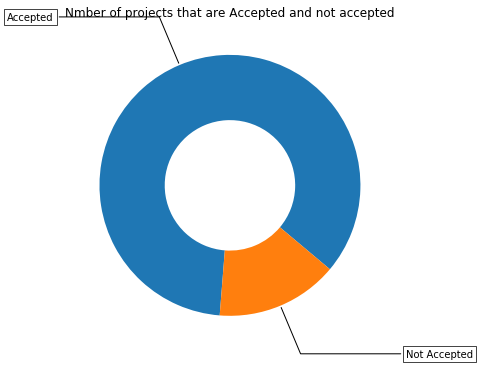

In [32]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
y_value_counts = project_data['project_is_approved'].value_counts()


print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

####  Observations:

- We can see that around 84% of the project proposals submitted by teachers are approved and around 15% of the proposals are not approved. We have an imbalanced dataset.

### 1.2.1 Univariate Analysis: School State

In [181]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039
temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
temp.columns = ['state_code', 'num_proposals']
print(temp.head(5))

  state_code  num_proposals
0         AK       0.840580
1         AL       0.854711
2         AR       0.831268
3         AZ       0.838379
4         CA       0.858136


In [35]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


#### Observations:
- We can see variability in the approval rate based on school state. Vermont(VT) has the lowest percentage approval of 80%, while Delaware(DE) has around 89% approval rate.
- Approval rate based on state lies between 80 to 89.7%, having an overall average of 84%.

<h3>Function definition for plotting Bar plors</h3>

In [36]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [37]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

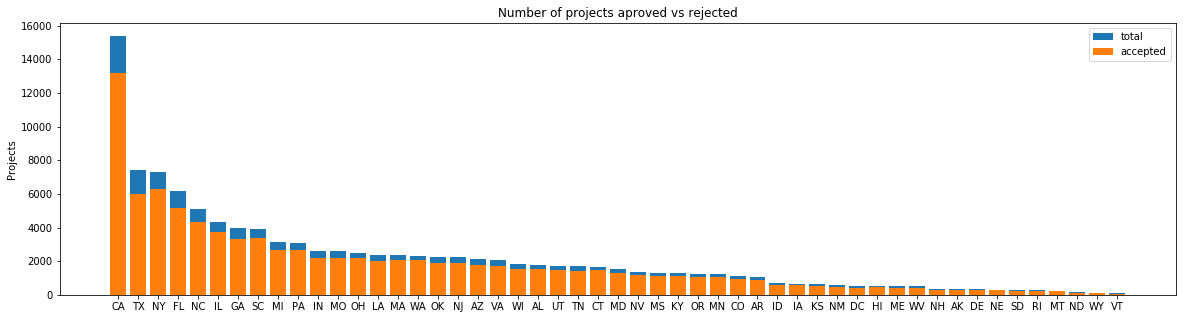

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [38]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

#### Observations: 
- From the bar plot as well as the numeric table representation, we can see that the total project submission based on state varies a lot. California lies at the top with 15388 project submissions out of which 13205 have been approved, giving an approval rate of approx 85%.
- Vermont has the least number of project submissions at 80 from which 64 have been approved. From the bar graph we can see that the number of project submissions based on state fall sharply

__SUMMARY: Every state has greater than 80% success rate in approval__

### 1.2.2 Univariate Analysis: teacher_prefix

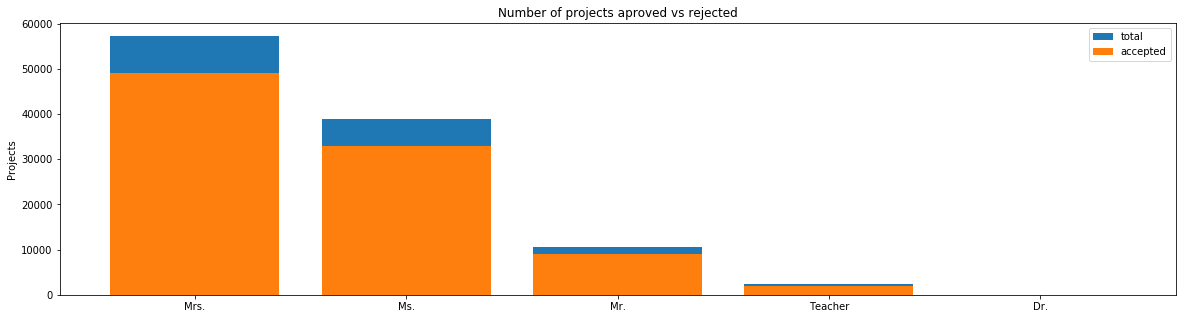

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [39]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

#### Observations:

- The number of project submission as well as the approval rate varies a lot depending on teacher prefix.
- We can see large number of project submission for teacher prefix 'Mrs', while the the number of submission for prefix 'Dr' is almost negligible as compared to 'Mrs'.
- The approval rate based on teacher prefix lies between 69.2% to 85.5%.

### 1.2.3 Univariate Analysis: project_grade_category

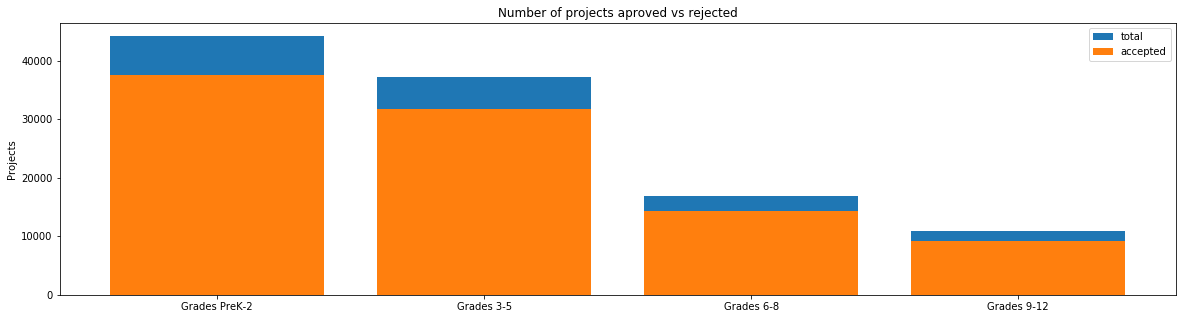

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [40]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

#### Observations:

- As compared to other features seen above, we can see slight variability in the approval rate based on project grade category.
- The number of project submission based on project grade varies a lot. Lower grades have higher number of project submission while the number of project submission decreases for higher grades.
- Grade 3-5 has the highest approval rate at 85.4% with second highest project submission of 37137.

### 1.2.4 Univariate Analysis: project_subject_categories

In [44]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())

In [45]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

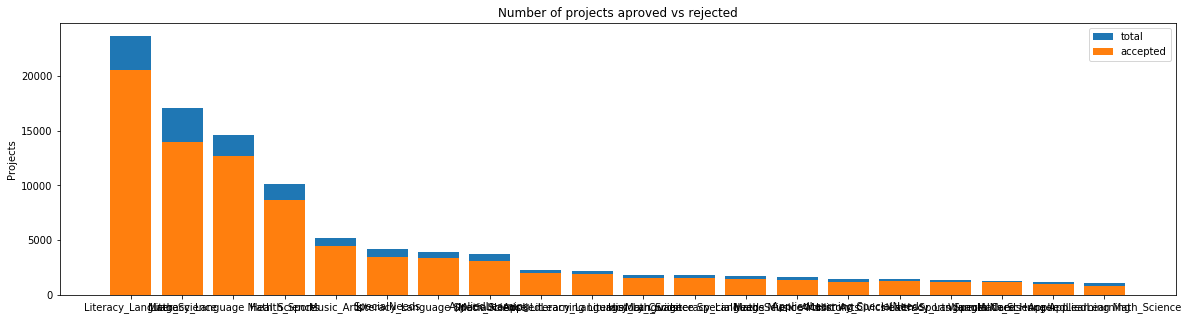

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [188]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

In [48]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())
print(my_counter)

Counter({'Literacy_Language': 52239, 'Math_Science': 41421, 'Health_Sports': 14223, 'SpecialNeeds': 13642, 'AppliedLearning': 12135, 'Music_Arts': 10293, 'History_Civics': 5914, 'Warmth': 1388, 'Care_Hunger': 1388})


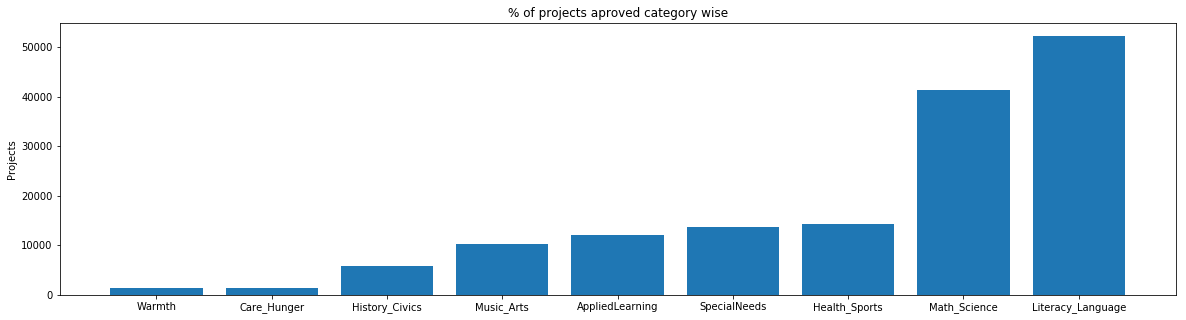

In [49]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [50]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


#### Observations:

- We have 9 unique subject categories, were project can belong to multiple categories. Literacy language category is present in 52239 projects, which is the highest.
- The number of project submission and approval rate varies a lot based on the subject category.
- Projects having categories belonging to social cause have higher approval rate, even though the number of project submission is low, for eg. Warmth,Care hunger, special needs.


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [52]:
sub_catogories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_catogories:
    temp = ""

    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [53]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

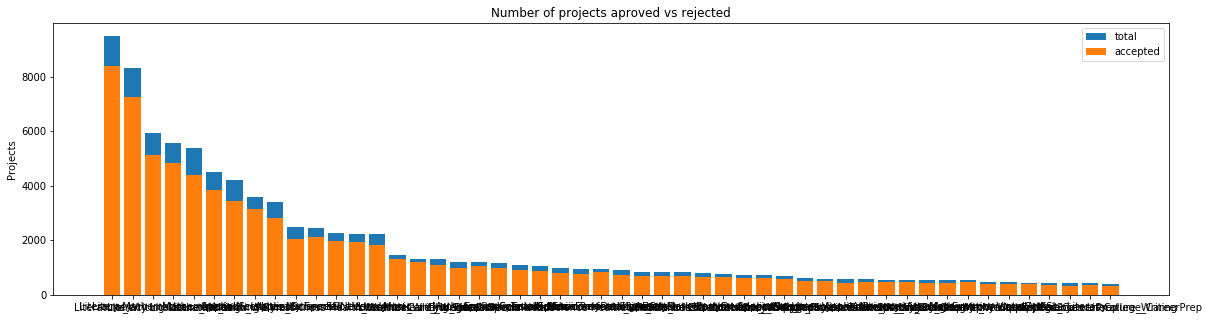

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [54]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [55]:
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

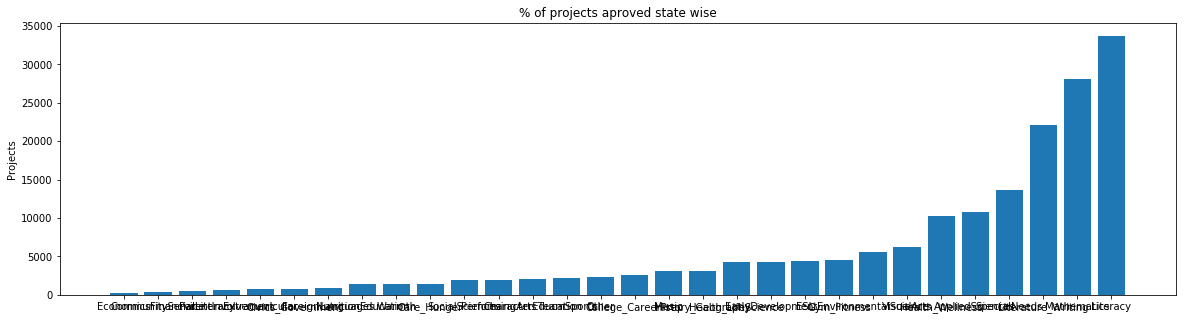

In [56]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [57]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


#### Observations:

- We can see that there are around 30 subcategories, where different subcategories can coexist. 
- Similar to subject categories, the number of project submission as well as approval rate varies a lot. Literacy sub category is present in almost 33k project submissions.

### 1.2.6 Univariate Analysis: Text features (Title)

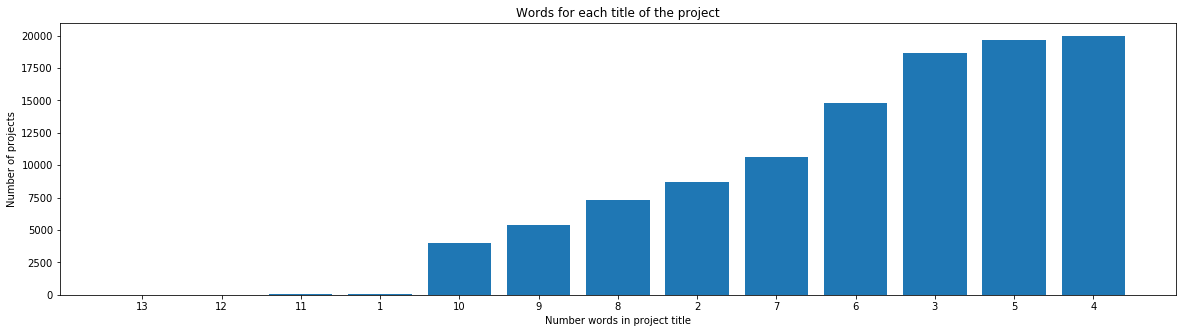

In [189]:
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [59]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

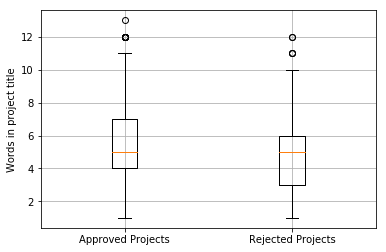

In [60]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

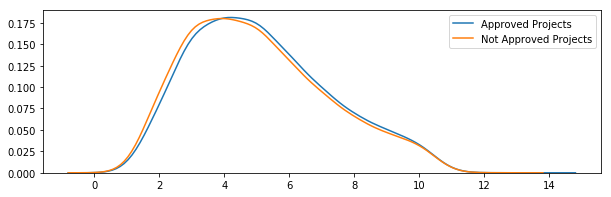

In [61]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

#### Observations:
- From the above bar graph and box plot, we can observe that most of the projects that have been submitted have 3-8 number of words in project title. 
- From the box plot, we can see that the 50th percentile of the number of words in project title is almost same for both the approved as well as the rejected projects. But the 25th and 75th percentile of approved projects is higher as compared to rejected projects. Approved projects have slightly higher number of words in project title.
- From the pdf also we can observe that the number of words in project title is slightly higher for approved projects(Blue line). When the number of words is less than 4 the chances of project proposal getting rejected is higher and when its more the 4 the chances of project proposal getting approved is higher.

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [62]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)


In [63]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

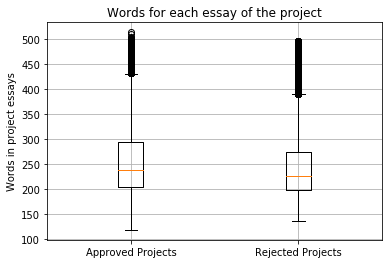

In [64]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

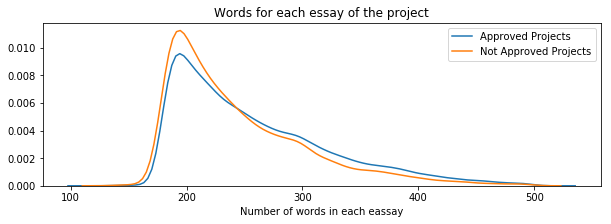

In [65]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

#### Observations:

- From the pdf and box plot we can see that the approved projects have slightly more number of words in essay as compared to rejected projects

### 1.2.8 Univariate Analysis: Cost per project

In [66]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [67]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [68]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [69]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

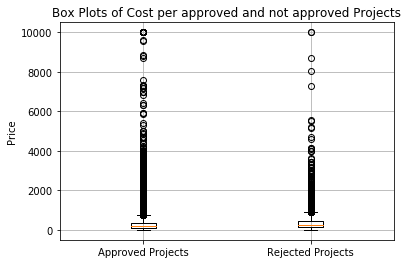

In [70]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

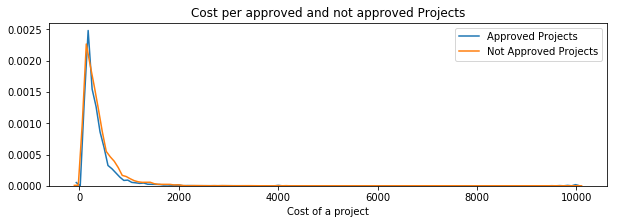

In [71]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [72]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

#### Observations:

- From the pdf and percentile table, we can observe that the chances of a project getting rejected is higher when the cost of project is higher.

<h3>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</h3>

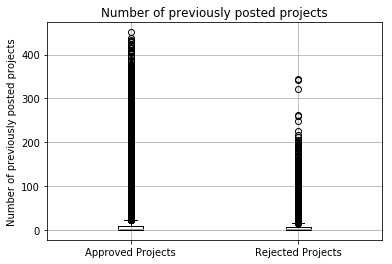

In [73]:
num_of_prev_posted_projects_approved=project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values
num_of_prev_posted_projects_rejected=project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values


# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([num_of_prev_posted_projects_approved, num_of_prev_posted_projects_rejected])
plt.title('Number of previously posted projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Number of previously posted projects')
plt.grid()
plt.show()


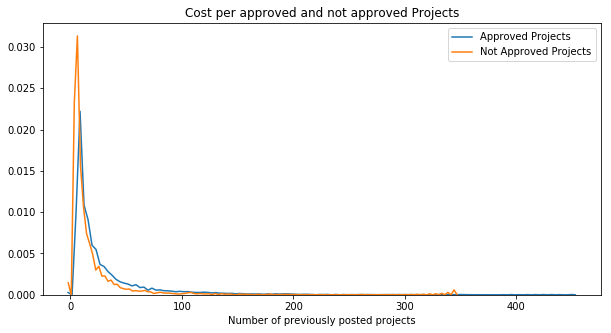

In [74]:
plt.figure(figsize=(10,5))
sns.distplot(num_of_prev_posted_projects_approved, hist=False, label="Approved Projects")
sns.distplot(num_of_prev_posted_projects_rejected, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Number of previously posted projects')
plt.legend()
plt.show()

In [190]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(num_of_prev_posted_projects_approved,i), 3), np.round(np.percentile(num_of_prev_posted_projects_rejected,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.0        |          0.0          |
|     5      |        0.0        |          0.0          |
|     10     |        0.0        |          0.0          |
|     15     |        0.0        |          0.0          |
|     20     |        0.0        |          0.0          |
|     25     |        0.0        |          0.0          |
|     30     |        1.0        |          0.0          |
|     35     |        1.0        |          1.0          |
|     40     |        1.0        |          1.0          |
|     45     |        2.0        |          1.0          |
|     50     |        2.0        |          2.0          |
|     55     |        3.0        |          2.0          |
|     60     |        4.0        |          3.0          |
|     65     |        5.0        |          3.0         

#### Observation:
- From the box plot we can't get much insights as almost 75 percent projects belonging to each class have less than 10 previously posted projects.
- From the above pdf and percentile table, we can observe that as the number of previously posted projects increases the chances of projects getting approved also increases slightly

<h3>1.2.10 Univariate Analysis: project_resource_summary</h3>

In [75]:
project_data['num_in_resource_summary']=project_data['project_resource_summary'].str.\
contains('\d| one | two | three | four | five | six | seven | eight | nine | ten | eleven | twelve | thirteen | fourteen | fifteen | sixteen | seventeen | eighteen | nineteen | twenty | thousand| hundred| lakh| crore|million',case = False).map({True:1,False:0})
project_data['num_in_resource_summary'].value_counts()

"\nresource_summary=list(project_data['project_resource_summary'])\n\nreg=re.compile(r'1|2|3|4|5|6|7|8|9|0')\nnum_in_resource_summary=[]\nfor i in resource_summary:\n    if(reg.search(i)==None):\n        num_in_resource_summary.append(0)\n    else:\n        num_in_resource_summary.append(1)\n        \n    \nproject_data['num_in_resource_summary']=num_in_resource_summary\nproject_data.head(15)\nproject_data['num_in_resource_summary'].value_counts()\n\n"

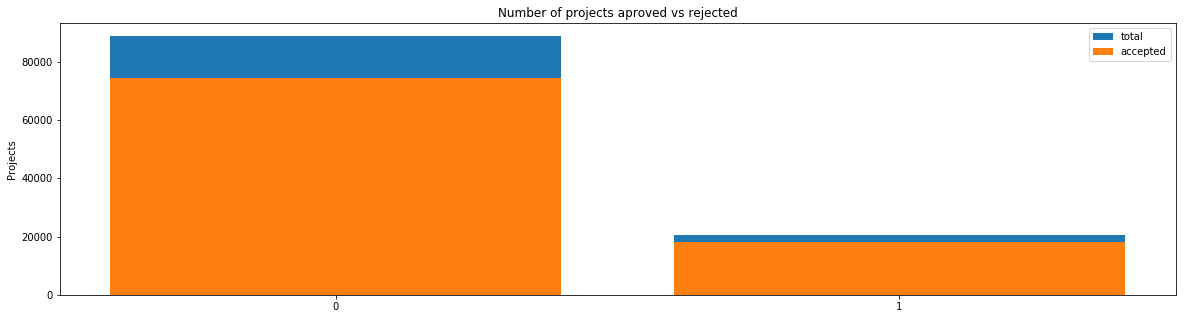

   num_in_resource_summary  project_is_approved  total       Avg
0                        0                74416  88835  0.837688
1                        1                18290  20413  0.895998
   num_in_resource_summary  project_is_approved  total       Avg
0                        0                74416  88835  0.837688
1                        1                18290  20413  0.895998


In [76]:
univariate_barplots(project_data, 'num_in_resource_summary', 'project_is_approved', top=50)

#### Observations:

- We can observe that around 20000 project proposal have numerical digits and 88000 project proposals do not have numerical digits in project resource summary.
- Although the number of projects having numerical digits is just around 20000, we can see that the chances of projects having numbers in resource summary, getting approved is aroung 89% which is higher than the reviews not having any numerical digits.


## 1.3 Text preprocessing

#### Selecting 5000 points randomly(2500 approved, 2500 rejected)

In [77]:
# Selecting 5000 points randomly from project_data such that 2500 points belong to each class
#Randomly select data from dataframe : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

reject_data=project_data[project_data.project_is_approved==0].sample(2500,random_state=1)
approved_data=project_data[project_data.project_is_approved==1].sample(2500,random_state=1)
project_data_5000=pd.concat([reject_data,approved_data],ignore_index=True)


### 1.3.1 Essay Text

In [79]:
project_data_5000.head(2)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0       74839  p176558  edb13de2014bdbdcce56cde3583431ec           Mrs.   
1       37318  p086064  15205456541f291feee3f76951efb302            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           GA        2016-07-09 22:36:04             Grades 3-5   
1           NY        2016-12-09 22:06:36            Grades 9-12   

     project_title                                    project_essay_1  \
0      New Teacher  We are the home of the Lions! We are proud to ...   
1  Lady Lions Lax!  At the Lehman Educational Campus student athle...   

                                     project_essay_2           ...             \
0  I am a new teacher and I need help making our ...           ...              
1  Proper equipment is essential to having a succ...           ...              

  project_essay_4                           project_resource_summary  \
0             NaN  My students need a warm inviting classroom in ...   
1             NaN  My students need these equipment bags, water b...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            1                    0   

                 clean_categories             clean_subcategories  \
0  Literacy_Language Math_Science  Literature_Writing Mathematics   
1                   Health_Sports      Health_Wellness TeamSports   

                                               essay   price  quantity  \
0  We are the home of the Lions! We are proud to ...  668.47        18   
1  At the Lehman Educational Campus student athle...  157.86        75   

   num_in_resource_summary  
0                        0  
1                        0  

[2 rows x 21 columns]

In [80]:
# printing some random essays.
print(project_data_5000['essay'].values[0])
print("="*50)
print(project_data_5000['essay'].values[150])
print("="*50)
print(project_data_5000['essay'].values[1000])
print("="*50)
print(project_data_5000['essay'].values[2000])
print("="*50)
print(project_data_5000['essay'].values[999])
print("="*50)


We are the home of the Lions! We are proud to be a Title I school but that does present some challenges.  A lot of our students live in Section 8 housing projects.  The majority of our students are on the free/reduced breakfast & lunch program.  Regardless of their socioeconomic challenges they come to school seeking a safe learning environment.  Please help me to create a welcoming space for them in my new classroom. Your donation will be greatly appreciated!I am a new teacher and I need help making our classroom awesome!  My students deserve a warm comfortable learning environment.  Right now our classroom is a beige brick cube with no windows.  Studies show that the use of bright vibrate colors help to stimulated the mind.  By donating to our project you will ultimately help to increase their academic achievement.  My students will feel welcomed and wanted every day.  They will see school, as I did, as a safe haven for kids.  An environment in which they can explore, thrive, and ach

In [81]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [82]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [83]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [84]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [85]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [86]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data_5000['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 730.41it/s]


In [87]:
# after preprocesing
preprocessed_essays[999]

'i realized change classroom change community change enough communities change world erin gruwell i would love add positive change classroom supplies my kids would benefit greatly academically behaviorally i teach high esl population public school low income rural area i 17 best first graders anyone could ask they always eager learn new things always try best every day no matter story kids love coming school every day i would love make even better give much needed supplies need my students need tables sit feel comfortable working challenging curriculum the printer would make class printing easier current one room always breaking last calendar would enhance morning meeting get kids great start any donation give greatly benefit class giving students nurturing environment deserve the supplies would allow organization would make every day school positive learning experience diverse learners nannan'

<h3>1.3.2 Project title Text</h3>

In [88]:
#Printing few random titles
print(project_data_5000['project_title'].values[0])
print("-"*50)
print(project_data_5000['project_title'].values[1000])
print("-"*50)
print(project_data_5000['project_title'].values[500])
print("-"*50)
print(project_data_5000['project_title'].values[600])
print("-"*50)
print(project_data_5000['project_title'].values[3000])

New Teacher
--------------------------------------------------
Real Life Reading Builds Strong Readers
--------------------------------------------------
Analog to Digital-Scanning for the Future
--------------------------------------------------
Options Create Interests!
--------------------------------------------------
Colors to Brighten the Room


In [89]:
# Preprocessing of project title

from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data_5000['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 13800.61it/s]


In [90]:
preprocessed_titles[3000]

'colors brighten room'

## 1. 4 Preparing data for models

In [91]:
project_data.columns
#project_data.head(2)

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'num_in_resource_summary'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [92]:
print(sorted_cat_dict)

{'Warmth': 1388, 'Care_Hunger': 1388, 'History_Civics': 5914, 'Music_Arts': 10293, 'AppliedLearning': 12135, 'SpecialNeeds': 13642, 'Health_Sports': 14223, 'Math_Science': 41421, 'Literacy_Language': 52239}


In [93]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data_5000['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data_5000['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (5000, 9)


In [94]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data_5000['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data_5000['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (5000, 30)


In [95]:
#One hot encoding for School state
vectorizer = CountVectorizer(vocabulary=project_data_5000['school_state'].unique().tolist(), lowercase=False, binary=True)
vectorizer.fit(project_data_5000['school_state'].values)
print(vectorizer.get_feature_names())


state_one_hot = vectorizer.transform(project_data_5000['school_state'].values)
print("Shape of matrix after one hot encodig ",state_one_hot.shape)

['GA', 'NY', 'IL', 'NC', 'PA', 'FL', 'CA', 'TN', 'AZ', 'AL', 'NJ', 'UT', 'KY', 'TX', 'CT', 'MO', 'WV', 'NM', 'OH', 'VA', 'MN', 'OK', 'OR', 'MS', 'LA', 'MI', 'SD', 'HI', 'NE', 'DC', 'MD', 'KS', 'NV', 'IN', 'SC', 'CO', 'WY', 'WI', 'WA', 'ID', 'AR', 'MA', 'ND', 'RI', 'MT', 'ME', 'NH', 'IA', 'AK', 'VT', 'DE']
Shape of matrix after one hot encodig  (5000, 51)


In [96]:
#Removing NaN from teacher prefix
project_data[project_data['teacher_prefix'].isna()==True]
project_data['teacher_prefix'].fillna(method='pad',inplace=True)

In [97]:
#One hot encoding for Teacher prefix
#Removing . from teacher_prefix
project_data['teacher_prefix'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')

vectorizer = CountVectorizer(vocabulary=project_data_5000['teacher_prefix'].unique().tolist(), lowercase=False, binary=True)
vectorizer.fit(project_data_5000['teacher_prefix'].values)
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(project_data_5000['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)

['Mrs.', 'Ms.', 'Mr.', 'Teacher', 'Dr.']
Shape of matrix after one hot encodig  (5000, 5)


In [98]:
#One hot encoding for project_grade_category
vectorizer = CountVectorizer(vocabulary=project_data_5000['project_grade_category'].unique().tolist(), lowercase=False, binary=True)
vectorizer.fit(project_data_5000['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grade_category_one_hot = vectorizer.transform(project_data_5000['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",project_grade_category_one_hot.shape)

['Grades 3-5', 'Grades 9-12', 'Grades 6-8', 'Grades PreK-2']
Shape of matrix after one hot encodig  (5000, 4)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [99]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (5000, 4312)


<h4>1.4.2.2 Bag of Words on `project_title`</h4>

In [100]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
title_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after BOW on project_title ",title_bow.shape)

Shape of matrix after BOW on project_title  (5000, 371)


#### 1.4.2.3 TFIDF vectorizer

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (5000, 4312)


<h4>1.4.2.4 TFIDF Vectorizer on `project_title`</h4>

In [102]:
# Similarly you can vectorize for title also
vectorizer = TfidfVectorizer(min_df=10)
title_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",title_tfidf.shape)

Shape of matrix after one hot encodig  (5000, 371)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [0]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [103]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [104]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1349.86it/s]


5000
300


<h4>1.4.2.6 Using Pretrained Models: AVG W2V on `project_title`</h4>

In [105]:
# Similarly you can vectorize for title also
#AVG W2V on project_title

avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title.append(vector)

print(len(avg_w2v_vectors_title))
print(len(avg_w2v_vectors_title[0]))

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 28502.39it/s]


5000
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [106]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


In [107]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 187.26it/s]


5000
300


<h4>1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on `project_title`</h4>

In [108]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model_x = TfidfVectorizer()
tfidf_model_x.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_title = dict(zip(tfidf_model_x.get_feature_names(), list(tfidf_model_x.idf_)))
tfidf_words_title = set(tfidf_model_x.get_feature_names())


tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_title):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_title[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title.append(vector)

print(len(tfidf_w2v_vectors_title))
print(len(tfidf_w2v_vectors_title[0]))

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 12482.97it/s]


5000
300


### 1.4.3 Vectorizing Numerical features

In [109]:
from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
price_scalar.fit(project_data_5000['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data_5000['price'].values.reshape(-1, 1))

Mean : 324.50971, Standard deviation : 375.46011319358


In [110]:
price_standardized

array([[ 0.91610341],
       [-0.44385463],
       [ 0.36528591],
       ...,
       [-0.75467327],
       [-0.61564385],
       [-0.5647463 ]])

In [111]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#Standardization of   quantity   
quantity_scalar=StandardScaler()
quantity_standardized=quantity_scalar.fit_transform(project_data_5000['quantity'].values.astype(float).reshape(-1,1))
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

Mean : 18.3136, Standard deviation : 26.32733285086053


In [112]:
print(quantity_standardized)

[[-0.01191158]
 [ 2.15313873]
 [-0.27779495]
 ...
 [ 1.58338865]
 [-0.4297283 ]
 [-0.61964499]]


In [113]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#Standardization of teacher_number_of_previously_posted_projects 
no_projects_scalar=StandardScaler()
no_projects_standardized=no_projects_scalar.fit_transform(project_data_5000['teacher_number_of_previously_posted_projects'].values.astype(float).reshape(-1,1))
print(f"Mean : {no_projects_scalar.mean_[0]}, Standard deviation : {np.sqrt(no_projects_scalar.var_[0])}")

Mean : 9.7066, Standard deviation : 26.09749636344452


### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [114]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

(5000, 9)
(5000, 30)
(5000, 4312)
(5000, 1)


In [115]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(5000, 4352)

<h1>Applying TSNE</h1>

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

In [116]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_title_Bow = hstack((categories_one_hot, sub_categories_one_hot,state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,\
            title_bow,\
            price_standardized,no_projects_standardized))
X_title_Bow=X_title_Bow.todense()

#Y_top5000 is the label
Y_top5000=project_data_5000['project_is_approved'].map({0:'Rejected',1:'Approved'})

print("X shape: ",X_title_Bow.shape," Y shape :", Y_top5000.shape)



X shape:  (5000, 472)  Y shape : (5000,)


In [117]:
print(Y_top5000.value_counts())

Approved    2500
Rejected    2500
Name: project_is_approved, dtype: int64


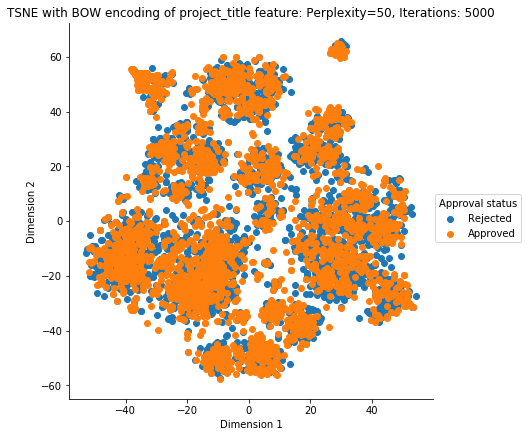

In [378]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=50)

tsne_data = model.fit_transform(X_title_Bow)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature: Perplexity=50, Iterations: 5000")
plt.show()

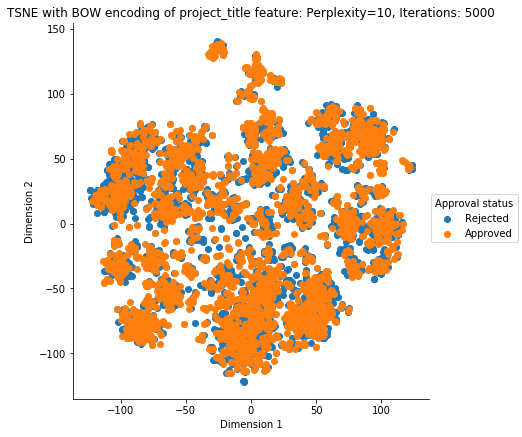

In [382]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=10)

tsne_data = model.fit_transform(X_title_Bow)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature: Perplexity=10, Iterations: 5000")
plt.show()

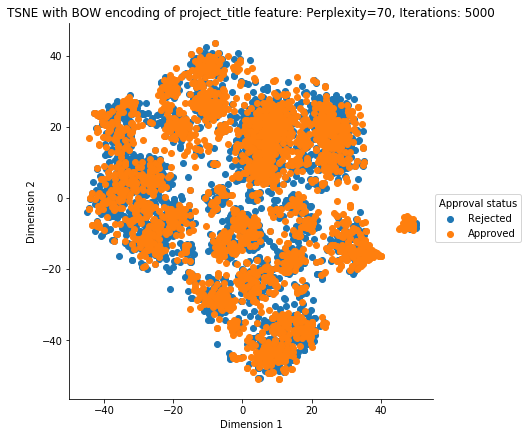

In [383]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=70)

tsne_data = model.fit_transform(X_title_Bow)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature: Perplexity=70, Iterations: 5000")
plt.show()

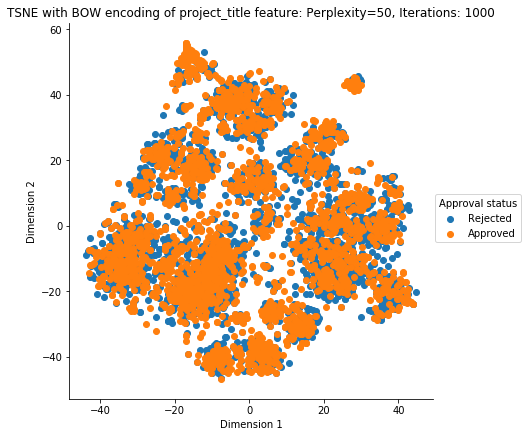

In [384]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)

tsne_data = model.fit_transform(X_title_Bow)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature: Perplexity=50, Iterations: 1000")
plt.show()

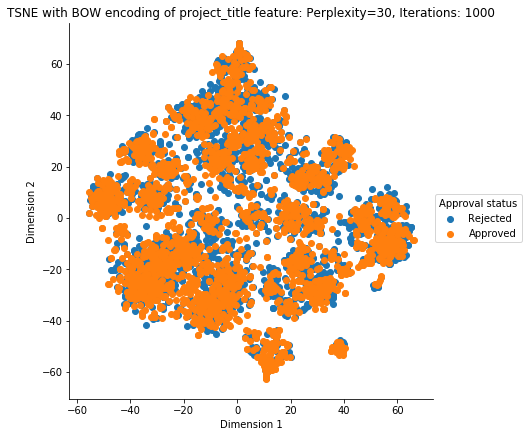

In [385]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=30)

tsne_data = model.fit_transform(X_title_Bow)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature: Perplexity=30, Iterations: 1000")
plt.show()

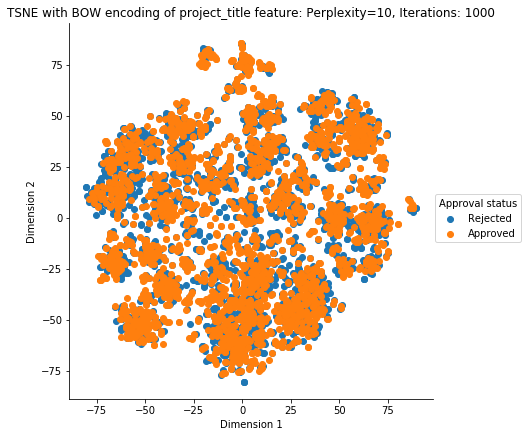

In [381]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=10)

tsne_data = model.fit_transform(X_title_Bow)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature: Perplexity=10, Iterations: 1000")
plt.show()

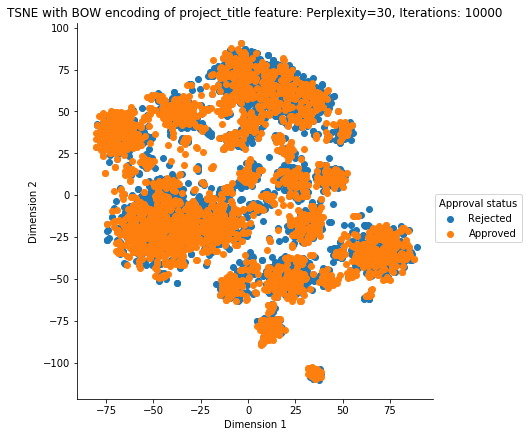

In [118]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=10000,perplexity=30)

tsne_data = model.fit_transform(X_title_Bow)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature: Perplexity=30, Iterations: 10000")
plt.show()

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

In [120]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_title_tfidf = hstack((categories_one_hot, sub_categories_one_hot,state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,\
            title_tfidf,\
            price_standardized,no_projects_standardized))

X_title_tfidf=X_title_tfidf.todense()

#Y_top5000 is the label
Y_top5000=project_data_5000['project_is_approved'].map({0:'Rejected',1:'Approved'})

print("X shape: ",X_title_tfidf.shape," Y shape :", Y_top5000.shape)

    

X shape:  (5000, 472)  Y shape : (5000,)


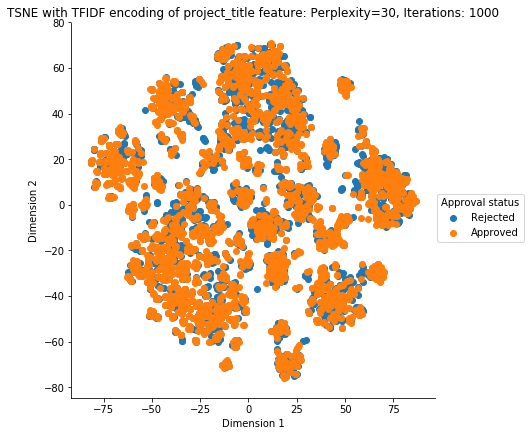

In [121]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=30)

tsne_data = model.fit_transform(X_title_tfidf)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF encoding of project_title feature: Perplexity=30, Iterations: 1000")
plt.show()

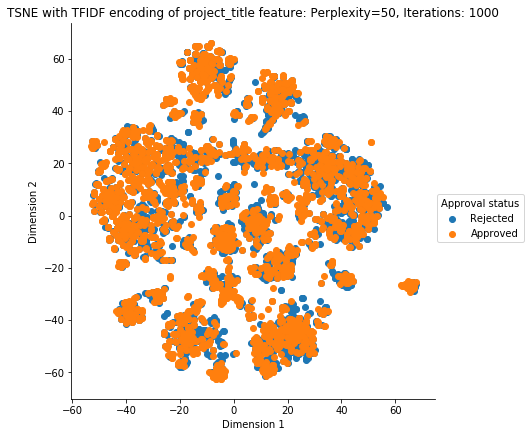

In [122]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=50)

tsne_data = model.fit_transform(X_title_tfidf)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF encoding of project_title feature: Perplexity=50, Iterations: 1000")
plt.show()

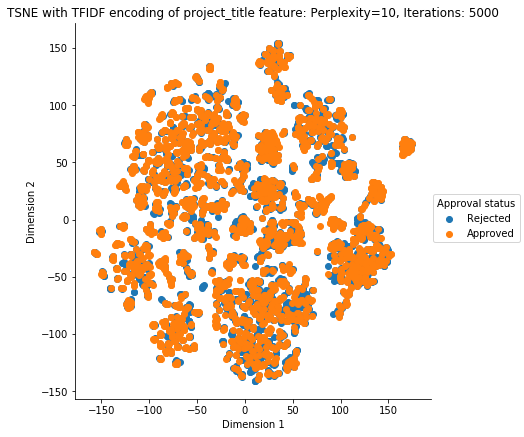

In [123]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=10)

tsne_data = model.fit_transform(X_title_tfidf)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF encoding of project_title feature: Perplexity=10, Iterations: 5000")
plt.show()

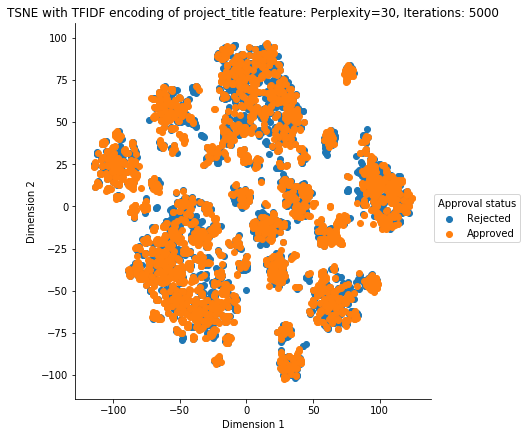

In [124]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=30)

tsne_data = model.fit_transform(X_title_tfidf)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF encoding of project_title feature: Perplexity=30, Iterations: 5000")
plt.show()

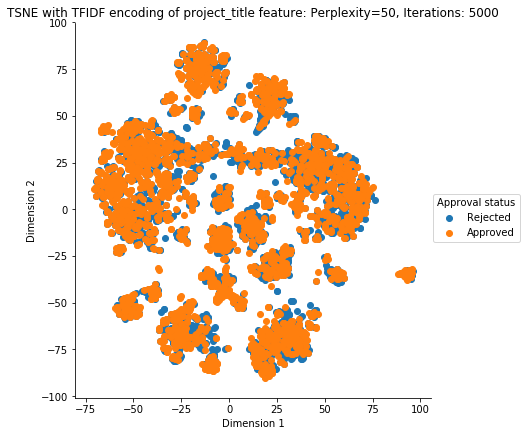

In [125]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=50)

tsne_data = model.fit_transform(X_title_tfidf)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF encoding of project_title feature: Perplexity=50, Iterations: 5000")
plt.show()

<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

In [126]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_title_avg_w2v = hstack((categories_one_hot, sub_categories_one_hot,state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,\
            avg_w2v_vectors_title,\
            price_standardized,no_projects_standardized))

X_title_avg_w2v=X_title_avg_w2v.todense()

#Y_top5000 is the label
Y_top5000=project_data_5000['project_is_approved'].map({0:'Rejected',1:'Approved'})

print("X shape: ",X_title_avg_w2v.shape," Y shape :", Y_top5000.shape)

    

X shape:  (5000, 401)  Y shape : (5000,)


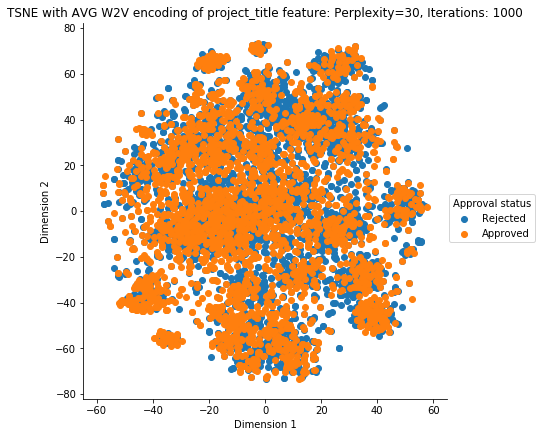

In [127]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=30)

tsne_data = model.fit_transform(X_title_avg_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with AVG W2V encoding of project_title feature: Perplexity=30, Iterations: 1000")
plt.show()

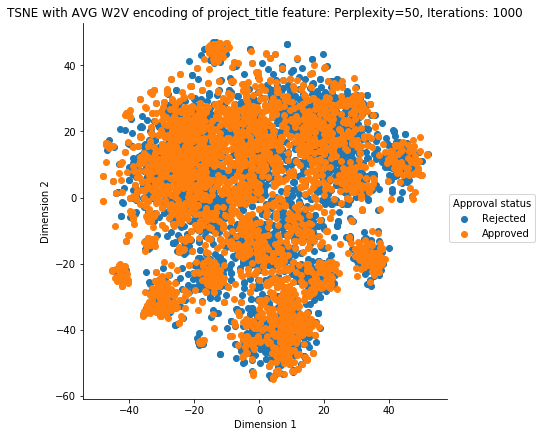

In [128]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=50)

tsne_data = model.fit_transform(X_title_avg_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with AVG W2V encoding of project_title feature: Perplexity=50, Iterations: 1000")
plt.show()

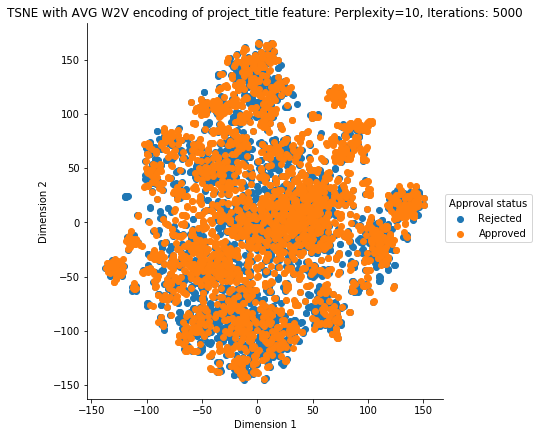

In [129]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=10)

tsne_data = model.fit_transform(X_title_avg_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with AVG W2V encoding of project_title feature: Perplexity=10, Iterations: 5000")
plt.show()

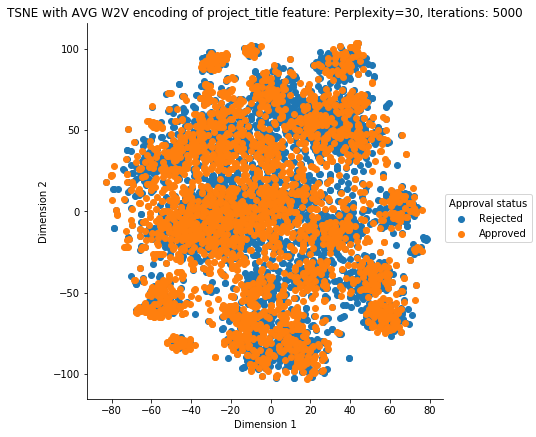

In [130]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=30)

tsne_data = model.fit_transform(X_title_avg_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with AVG W2V encoding of project_title feature: Perplexity=30, Iterations: 5000")
plt.show()

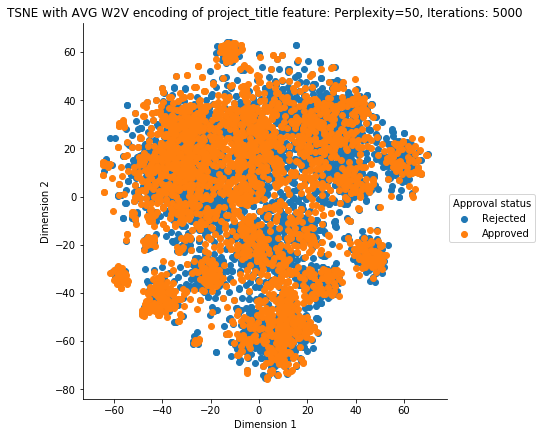

In [131]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=50)

tsne_data = model.fit_transform(X_title_avg_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with AVG W2V encoding of project_title feature: Perplexity=50, Iterations: 5000")
plt.show()

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [132]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_title_tfidf_w2v = hstack((categories_one_hot, sub_categories_one_hot,state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,\
            tfidf_w2v_vectors_title,\
            price_standardized,no_projects_standardized))

X_title_tfidf_w2v=X_title_tfidf_w2v.todense()

#Y_top5000 is the label
Y_top5000=project_data_5000['project_is_approved'].map({0:'Rejected',1:'Approved'})

print("X shape: ",X_title_tfidf_w2v.shape," Y shape :", Y_top5000.shape)

    

X shape:  (5000, 401)  Y shape : (5000,)


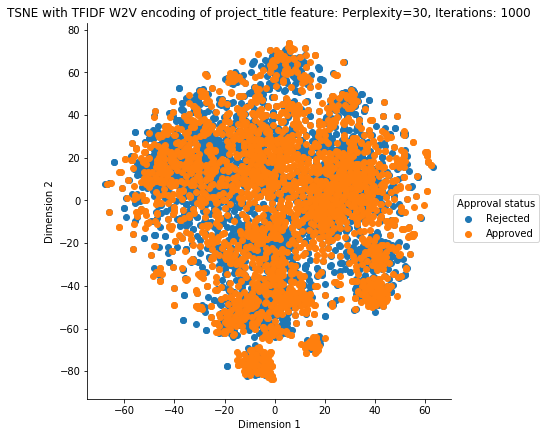

In [133]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=30)

tsne_data = model.fit_transform(X_title_tfidf_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF W2V encoding of project_title feature: Perplexity=30, Iterations: 1000")
plt.show()

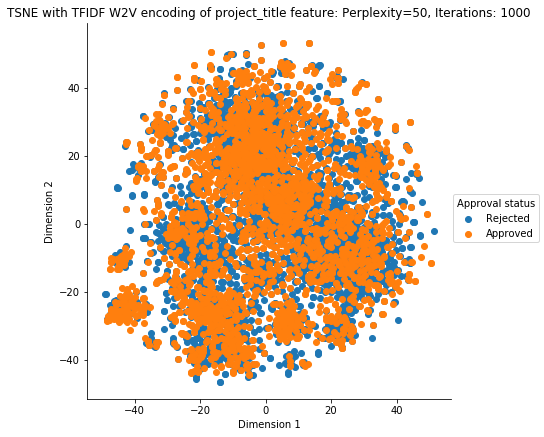

In [134]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=50)

tsne_data = model.fit_transform(X_title_tfidf_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF W2V encoding of project_title feature: Perplexity=50, Iterations: 1000")
plt.show()

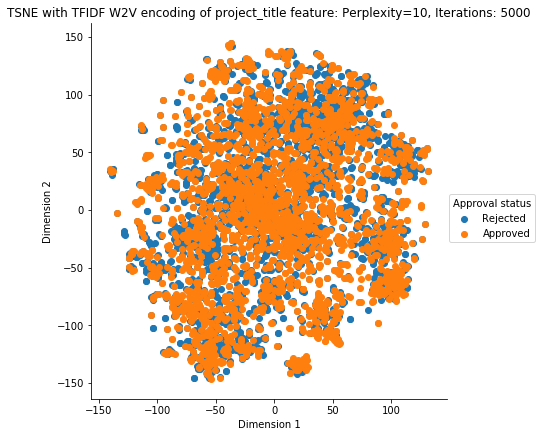

In [135]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=10)

tsne_data = model.fit_transform(X_title_tfidf_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF W2V encoding of project_title feature: Perplexity=10, Iterations: 5000")
plt.show()

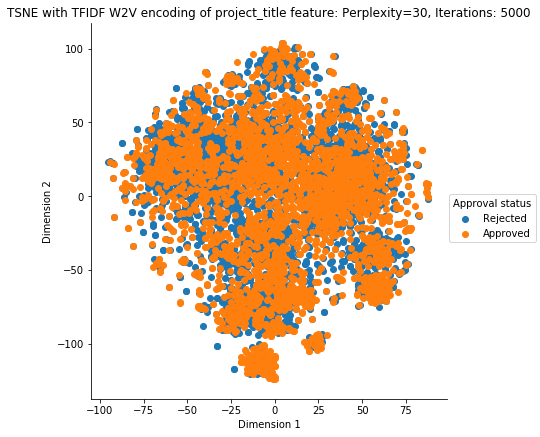

In [136]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=30)

tsne_data = model.fit_transform(X_title_tfidf_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF W2V encoding of project_title feature: Perplexity=30, Iterations: 5000")
plt.show()

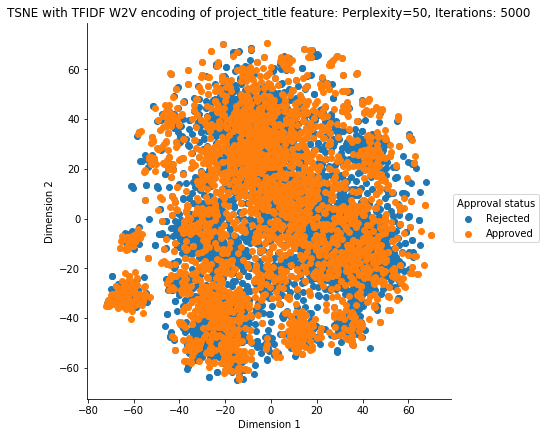

In [137]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=50)

tsne_data = model.fit_transform(X_title_tfidf_w2v)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with TFIDF W2V encoding of project_title feature: Perplexity=50, Iterations: 5000")
plt.show()

<h2> 2.5 TSNE with `BOW, TFIDF, AVG W@V, TFIDF W2V` encoding of `project_title` feature </h2>

In [138]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_title_all = hstack((categories_one_hot, sub_categories_one_hot,state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,\
            title_bow,title_tfidf,avg_w2v_vectors_title,tfidf_w2v_vectors_title,\
            price_standardized,no_projects_standardized))

X_title_all=X_title_all.todense()

#Y_top5000 is the label
Y_top5000=project_data_5000['project_is_approved'].map({0:'Rejected',1:'Approved'})

print("X shape: ",X_title_all.shape," Y shape :", Y_top5000.shape)

    

X shape:  (5000, 1443)  Y shape : (5000,)


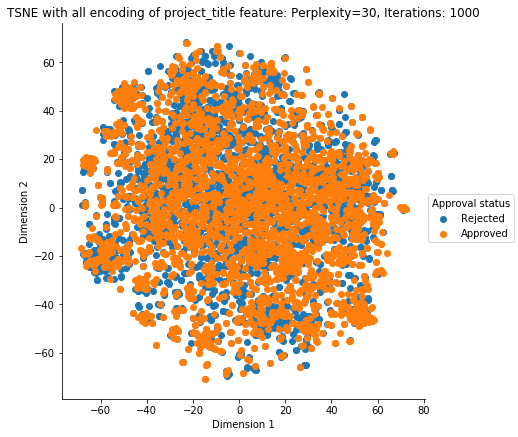

In [139]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=30)

tsne_data = model.fit_transform(X_title_all)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with all encoding of project_title feature: Perplexity=30, Iterations: 1000")
plt.show()

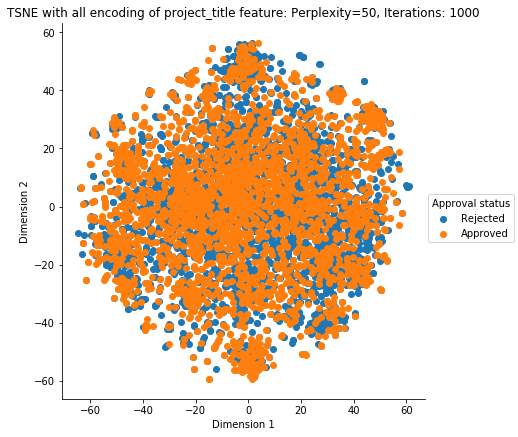

In [140]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=1000,perplexity=50)

tsne_data = model.fit_transform(X_title_all)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with all encoding of project_title feature: Perplexity=50, Iterations: 1000")
plt.show()

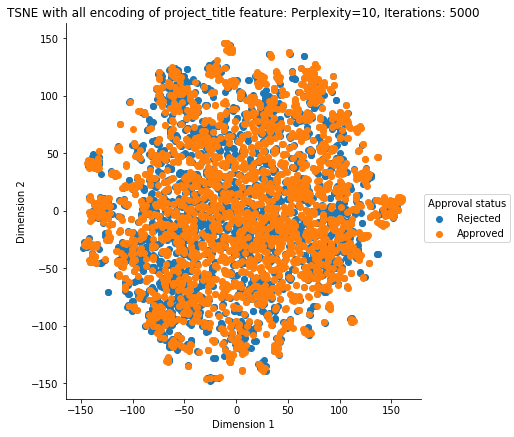

In [141]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=10)

tsne_data = model.fit_transform(X_title_all)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with all encoding of project_title feature: Perplexity=10, Iterations: 5000")
plt.show()

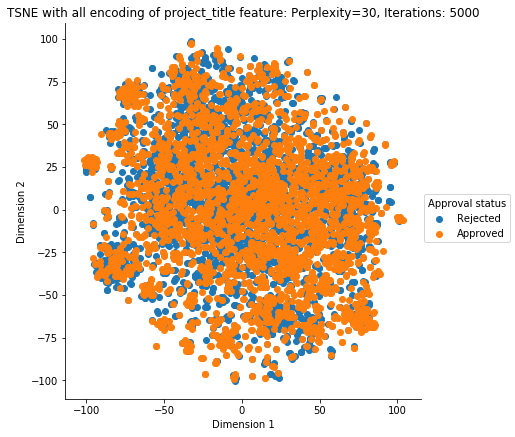

In [142]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=30)

tsne_data = model.fit_transform(X_title_all)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with all encoding of project_title feature: Perplexity=30, Iterations: 5000")
plt.show()

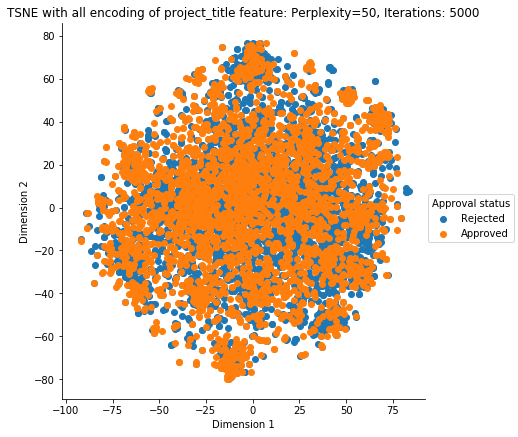

In [144]:
#TSNE implementation :  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,n_iter=5000,perplexity=50)

tsne_data = model.fit_transform(X_title_all)

tsne_data = np.vstack((tsne_data.T, Y_top5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Approval status"))


sn.FacetGrid(tsne_df, hue="Approval status", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title("TSNE with all encoding of project_title feature: Perplexity=50, Iterations: 5000")
plt.show()

<h2> 2.6 Summary </h2>

- Above, we can see visualization of different features using tsne with different perplexity and number of iterations.
    - categorical, numerical features + project_title(BOW)
    - categorical, numerical features + project_title(TFIDF)
    - categorical, numerical features + project_title(AVG W2V)
    - categorical, numerical features + project_title(TFIDF W2V)
    - categorical, numerical features + project_title(BOW) + project_title(TFIDF) + project_title(AVG W2V) + project_title(TFIDF W2V)
- We can see overlapping in all the visualizations and it is not possible to linearly separate the two class types using above visualiations.